## Dependencies

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

## Web Scraping

In [4]:
books=[]
for i in range(1,51):
  url= f"http://books.toscrape.com/catalogue/page-{i}.html"
  response = requests.get(url)
  response = response.content
  soup = BeautifulSoup(response,'html.parser')
  ol = soup.find('ol')
  articles= ol.findAll('article',class_='product_pod')

  for article in articles:
    image = article.find('img')
    title = image.attrs['alt']
    #print(title)
    star = article.find('p')
    star = star['class'][1]
    #print(star)
    price = article.find('p',class_='price_color').text
    price = float(price[1:])
    #print(price)
    stock = article.find('p',class_='instock availability').text.strip()
    #stock = stock.replace('\n', '')
    #print(stock)
    books.append([title,price,star,stock])

In [5]:
df = pd.DataFrame(books, columns=['Title', 'Price', 'StarRating', 'Available'])

In [6]:
df.head()

,Title,Price,StarRating,Available
0,A Light in the Attic,51.77,Three,In stock
1,Tipping the Velvet,53.74,One,In stock
2,Soumission,50.10,One,In stock
3,Sharp Objects,47.82,Four,In stock
4,Sapiens: A Brief History of Humankind,54.23,Five,In stock


In [7]:
# Add a book ID column with a range of numbers
df['Book_ID'] = range(len(df))
df.set_index('Book_ID', inplace=True)
df.head()

,Title,Price,StarRating,Available
Book_ID,,,,
0,A Light in the Attic,51.77,Three,In stock
1,Tipping the Velvet,53.74,One,In stock
2,Soumission,50.10,One,In stock
3,Sharp Objects,47.82,Four,In stock
4,Sapiens: A Brief History of Humankind,54.23,Five,In stock


## Data Cleaning

### Removing Special Characters and Punctuation

In [10]:
import re

def remove_special_chars(text):
    # Remove anything that is not a letter, number, or whitespace
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text

In [11]:
df['Title'] = df['Title'].apply(remove_special_chars)

In [12]:
df['Title'].head()

Book_ID
0                    A Light in the Attic
1                      Tipping the Velvet
2                              Soumission
3                           Sharp Objects
4    Sapiens A Brief History of Humankind
Name: Title, dtype: object

### Identify Duplicates Based on a Subset of Columns

In [14]:
# The total number of rows in a df
df.shape[0]

1000

In [15]:
duplicate_title = df.duplicated(subset=['Title'], keep=False)
duplicate_title_rows = df[duplicate_title]
print("\nDuplicate rows based on 'Title':")
duplicate_title_rows


Duplicate rows based on 'Title':


,Title,Price,StarRating,Available
Book_ID,,,,
236,The StarTouched Queen,46.02,Five,In stock
358,The StarTouched Queen,32.30,Five,In stock


In [16]:
# Drop duplicate rows based on 'Title' and keep the last occurrence
df_cleaned = df.drop_duplicates(subset=['Title'], keep='last')

In [17]:
# The total number of rows in a df after dropping duplicates
df_cleaned.shape[0]

999

### Custom or equal-width bins of Price

In [19]:
bins = [0, 25, 50, 75]
labels = ['Low', 'Medium', 'High']
df_cleaned['PriceCategory'] = pd.cut(df_cleaned['Price'], bins=bins, labels=labels, right=True)

df_cleaned.head()

,Title,Price,StarRating,Available,PriceCategory
Book_ID,,,,,
0,A Light in the Attic,51.77,Three,In stock,High
1,Tipping the Velvet,53.74,One,In stock,High
2,Soumission,50.10,One,In stock,High
3,Sharp Objects,47.82,Four,In stock,Medium
4,Sapiens A Brief History of Humankind,54.23,Five,In stock,High


### Checking Blank or Null Values

In [21]:
blank = df_cleaned[(df_cleaned['Title'] == '') | (df_cleaned['Price'] == 0.0)\
                   | (df_cleaned['StarRating'] == '') | (df_cleaned['Available'] == '')\
                   | (df_cleaned['PriceCategory'] == '')]

blank

,Title,Price,StarRating,Available,PriceCategory
Book_ID,,,,,


In [22]:
df_cleaned.isnull().sum()

Title            0
Price            0
StarRating       0
Available        0
PriceCategory    0
dtype: int64

### Saving a DataFrame to a CSV File

In [24]:
df_cleaned.to_csv('books.csv', index=True)

### Export a DataFrame to a PostgreSQL DB

In [26]:
!pip install pandas sqlalchemy psycopg2-binary

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 1.9 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.7 MB 1.4 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.7 MB 1.4 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.7 MB 1.4 MB/s eta 0:00:02
   --------------- ------------------------ 1.0/2.7 MB 718.9 kB/s eta 0:00:03
   ----------------------- ---------------- 1.6/2.7 MB 1.1 MB/s eta 0:00:02
   --------------------------- ------------ 1.8/2.7 MB 1.1 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.7 MB 1.2 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.7 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 1.2 MB/s eta 0:00:00


In [27]:
from sqlalchemy import create_engine
import pandas as pd

# Replace with your PostgreSQL connection details
db_user = "postgres"
db_password = "ndahadmin"
db_host = "localhost"  # or your host IP/name
db_port = "5432"
db_name = "webscraping"

# Create the connection string
engine_str = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(engine_str)
#conn = engine.connect()

In [28]:
table_name = "books"  # Name of the table in PostgreSQL

df_cleaned.to_sql(
    table_name,
    engine,
    if_exists='replace',  # Options: 'fail', 'replace', 'append'
    index=True           # Set to True if you want to export the DataFrame index as a column
)

print(f"DataFrame successfully exported to '{table_name}' in PostgreSQL.")

DataFrame successfully exported to 'books' in PostgreSQL.


## EDA (Exploratory Data Analysis)

In [30]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Title          999 non-null    object  
 1   Price          999 non-null    float64 
 2   StarRating     999 non-null    object  
 3   Available      999 non-null    object  
 4   PriceCategory  999 non-null    category
dtypes: category(1), float64(1), object(3)
memory usage: 40.1+ KB


In [31]:
soldout = df_cleaned[df_cleaned['Available'] != 'In stock']
soldout.head()

,Title,Price,StarRating,Available,PriceCategory
Book_ID,,,,,


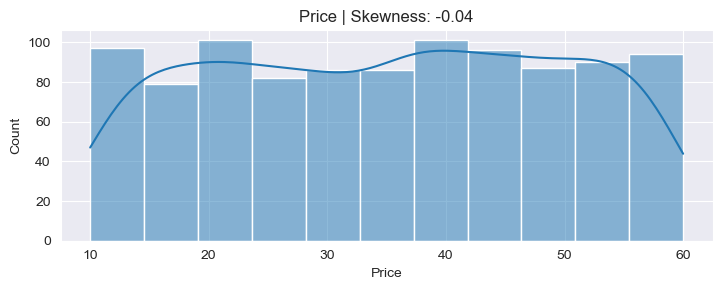

In [32]:
# Distribution of Numerical columns
sns.set_style("darkgrid")

numerical_columns = df_cleaned.select_dtypes(include=["int64","float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df_cleaned[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df_cleaned[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

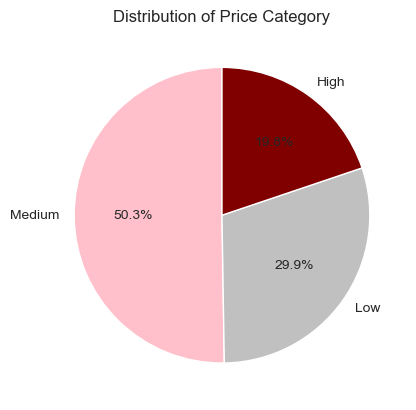

In [33]:
# Pie chart of Price Category
# Most of the books here have medium price, between 25-50 dollars
a = ['pink', 'silver', 'maroon'] # colors

counts = df_cleaned['PriceCategory'].value_counts()
counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=a)
plt.title('Distribution of Price Category')
plt.ylabel('')
plt.show()

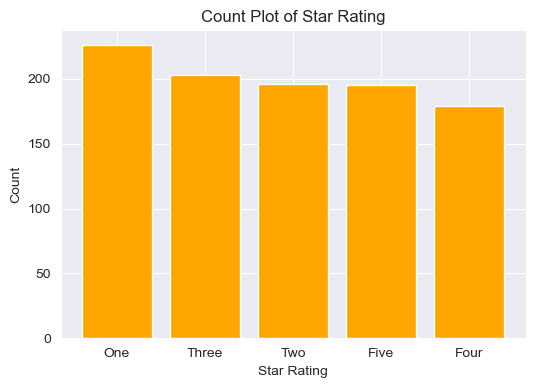

In [34]:
# Bar plot of Star Rating
# Most of the books here have a 1 star rating
reviewstar = df_cleaned['StarRating'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(reviewstar.index, reviewstar, color='orange')
plt.title('Count Plot of Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='StarRating', ylabel='Price'>

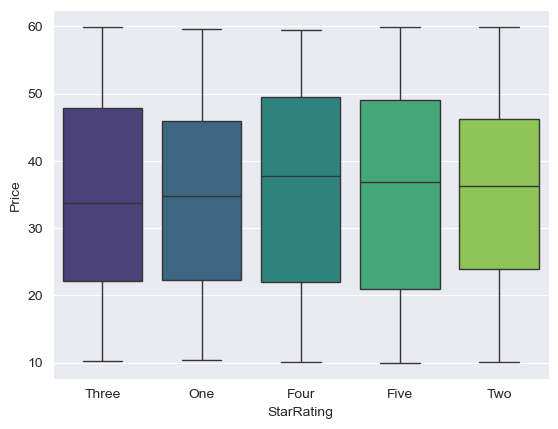

In [35]:
# Distribution of Star Rating and Price
# 5 star books is worth to buy, its have a wider price range and the most dominant price is around 37 dollars
sns.boxplot(x='StarRating', y='Price', data=df_cleaned, palette='viridis')